## Notebook for the Crossflow Paper

### Import Libaries

In [ ]:
#!mkdir data
#!gdown 1CVAQDuPOiwm8h9LJ8a_oOs6zOWS6EgkB
#!gdown 1ykZ9fjTxUwdiEwqagoYZiMcD5aG-7rHe
#!unzip -o test.zip -d data
#!unzip -o train.zip -d data
#from google.colab import drive
# drive.mount('/content/drive')
#!git clone https://github.com/Mamiglia/challenge.git

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from pathlib import Path
from tqdm import tqdm

from challenge.src.common import load_data, prepare_train_data, generate_submission

### Create Neural Network Architectures

- VAE-ENCODER (1024) -> LATENT SPACE (1536) -> VAE-DECODER (1024) train a VAE in parallel with the crossflow network
- CROSSFLOW GETS THE LATENT SPACE FROM VAE AS INPUT
-> INPUT (1024) -> VAE-ENCODER (1536) -> INPUT FOR CROSSFLOW -> CROSSFLOW TRANSFORMER -> OUTPUT FOR CROSSFLOW (1536)
- Use Text Embeddings as input for vae and image embeddings for crossflow
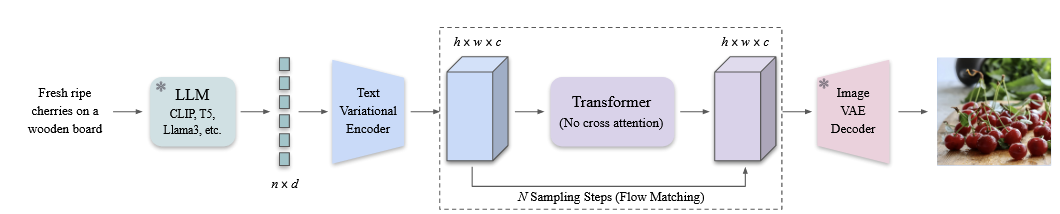

In [3]:
class MLPBlock(nn.Module):
    """Simple MLP block with LayerNorm, activation, and dropout"""
    def __init__(self, in_dim, out_dim, dropout=0.0, activation=nn.GELU):
        super().__init__()
        self.block = nn.Sequential(
            nn.LayerNorm(in_dim),
            nn.Linear(in_dim, out_dim),
            activation(),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.block(x)


class ContextMapperVAE(nn.Module):
    """
    Configurable VAE:
    - input_dim: dimension of the context embeddings
    - latent_dim: dimension of the target/image latent
    - num_layers: number of hidden layers for encoder/decoder
    - hidden_dim: width of hidden layers
    - dropout: dropout probability
    """
    def __init__(self, input_dim, latent_dim, num_layers=2, hidden_dim=512, dropout=0.1):
        super().__init__()
        # ---------------- Encoder ----------------
        enc_layers = []
        dim_in = input_dim
        for _ in range(num_layers):
            enc_layers.append(MLPBlock(dim_in, hidden_dim, dropout))
            dim_in = hidden_dim
        self.encoder_backbone = nn.Sequential(*enc_layers)
        self.encoder_head = nn.Linear(hidden_dim, latent_dim * 2)  # μ and logσ

        # ---------------- Decoder ----------------
        dec_layers = []
        dim_in = latent_dim
        for _ in range(num_layers):
            dec_layers.append(MLPBlock(dim_in, hidden_dim, dropout))
            dim_in = hidden_dim
        self.decoder_backbone = nn.Sequential(*dec_layers)
        self.decoder_head = nn.Linear(hidden_dim, input_dim)

    def forward(self, x):
        # --- Encoder path ---
        h = self.encoder_backbone(x)
        stats = self.encoder_head(h)
        mu, log_sigma = stats.chunk(2, dim=-1)
        sigma = torch.exp(log_sigma)
        eps = torch.randn_like(mu)
        z0 = mu + sigma * eps

        # --- Decoder path ---
        h_dec = self.decoder_backbone(z0)
        x_recon = self.decoder_head(h_dec)
        return z0, mu, log_sigma, x_recon

    def kl_loss(self, mu, log_sigma):
        # KL(q(z|x) || N(0,1))
        return -0.5 * torch.sum(1 + 2 * log_sigma - mu.pow(2) - torch.exp(2 * log_sigma), dim=-1).mean()


In [4]:
class TransformerFlow(nn.Module):
    """
    Configurable Transformer Flow model:
    - latent_dim: dimension of z_t
    - num_layers: number of transformer encoder layers
    - num_heads: number of attention heads
    - ff_dim: feed-forward hidden dimension
    - dropout: dropout in transformer layers
    """
    def __init__(self, latent_dim, num_layers=4, num_heads=4, ff_dim=512, dropout=0.1):
        super().__init__()
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=latent_dim,
            nhead=num_heads,
            dim_feedforward=ff_dim,
            dropout=dropout,
            activation='gelu',
            batch_first=True,
            norm_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output = nn.Linear(latent_dim, latent_dim)

    def forward(self, z_t, t):
        # Add sinusoidal time embedding
        t_embed = self.time_embedding(t, z_t.size(-1))
        x = z_t + t_embed
        x = x.unsqueeze(1)  # transformer expects sequence
        x = self.transformer(x)
        return self.output(x.squeeze(1))

    def time_embedding(self, t, dim):
        half_dim = dim // 2
        freqs = torch.exp(
            torch.arange(half_dim, device=t.device) * (-torch.log(torch.tensor(10000.0)) / (half_dim - 1))
        )
        angles = t.unsqueeze(1) * freqs.unsqueeze(0)
        emb = torch.cat([torch.sin(angles), torch.cos(angles)], dim=-1)
        return emb


In [5]:
def training_step(context_emb, image_emb, vae, flow, optimizer, lambda_kl=1e-4):
    z0, mu, log_sigma, recon = vae(context_emb)
    z1 = image_emb

    t = torch.rand(z0.size(0), 1, device=z0.device)
    z_t = (1 - t) * z0 + t * z1
    v_hat = z1 - z0
    v_pred = flow(z_t, t.squeeze())

    L_FM = F.mse_loss(v_pred, v_hat)
    L_Enc = F.mse_loss(recon, context_emb)
    L_KL = vae.kl_loss(mu, log_sigma)

    loss = L_FM + L_Enc + lambda_kl * L_KL
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    return {"loss": loss.item(), "L_FM": L_FM.item(), "L_Enc": L_Enc.item(), "L_KL": L_KL.item()}


In [6]:
@torch.no_grad()
def integrate_flow(flow, z0, n_steps=20):
    z = z0.clone()
    t_values = torch.linspace(0, 1, n_steps, device=z0.device)
    dt = 1.0 / n_steps
    for t in t_values:
        v = flow(z, t.repeat(z.size(0)))
        z = z + dt * v
    return z


In [10]:
import torch
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np

def train_epoch(train_loader, vae, flow, optimizer, lambda_kl=1e-4, device="cuda", epoch = 0):
    vae.train()
    flow.train()
    total_loss, total_fm, total_enc, total_kl = 0, 0, 0, 0

    for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch: {epoch}"):
        context = X_batch
        image = y_batch

        z0, mu, log_sigma, recon = vae(context)
        z1 = image

        t = torch.rand(z0.size(0), 1, device=device)
        z_t = (1 - t) * z0 + t * z1
        v_hat = z1 - z0
        v_pred = flow(z_t, t.squeeze())

        L_FM = F.mse_loss(v_pred, v_hat)
        L_Enc = F.mse_loss(recon, context)
        L_KL = vae.kl_loss(mu, log_sigma)

        loss = L_FM + L_Enc + lambda_kl * L_KL

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_fm += L_FM.item()
        total_enc += L_Enc.item()
        total_kl += L_KL.item()

    n = len(train_loader)
    return {
        "loss": total_loss / n,
        "L_FM": total_fm / n,
        "L_Enc": total_enc / n,
        "L_KL": total_kl / n
    }


@torch.no_grad()
def validate_epoch(val_loader, vae, flow, device="cuda", n_steps=20):
    vae.eval()
    flow.eval()
    cos_sims = []

    for X_batch, y_batch in tqdm(val_loader, desc="Validation"):
        context = X_batch
        image = y_batch

        # Encode to z0
        z0, _, _, _ = vae(context)

        # Integrate flow to predict target embedding
        z1_pred = integrate_flow(flow, z0, n_steps=n_steps)
        z1_true = image

        # Compute cosine similarity between predicted and true image embeddings
        cos_sim = F.cosine_similarity(z1_pred, z1_true, dim=-1)
        cos_sims.append(cos_sim.cpu().numpy())

    cos_sims = np.concatenate(cos_sims)
    mean_cosine = np.mean(cos_sims)
    acc_80 = np.mean(cos_sims > 0.8)  # how often similarity > 0.8
    acc_90 = np.mean(cos_sims > 0.9)

    return {
        "mean_cosine": mean_cosine,
        "acc@0.8": acc_80,
        "acc@0.9": acc_90
    }


### Load Data

In [13]:
# 3. Crossflow
# 4. Data Augmentation
# 5. Zero Shot Stitching
# 6. Diffusion Priors
# Configuration
EPOCHS = 60
BATCH_SIZE = 128
LR = 0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Load data
train_data = load_data("data/train/train.npz")
X, y, label = prepare_train_data(train_data)
DATASET_SIZE = len(X)
# Split train/val
# This is done only to measure generalization capabilities, you don't have to
# use a validation set (though we encourage this)
n_train = int(0.9 * len(X))
TRAIN_SPLIT = torch.zeros(len(X), dtype=torch.bool)
TRAIN_SPLIT[:n_train] = 1
X_train, X_val = X[TRAIN_SPLIT], X[~TRAIN_SPLIT]
y_train, y_val = y[TRAIN_SPLIT], y[~TRAIN_SPLIT]


train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
y_train.shape, X_train.shape, train_loader.batch_size, val_loader.batch_size

(125000,)
Train data: 125000 captions, 125000 images


(torch.Size([112500, 1536]), torch.Size([112500, 1024]), 128, 128)

In [12]:

vae = ContextMapperVAE(
    input_dim=1024, latent_dim=1536,
    num_layers=3, hidden_dim=1024, dropout=0.1
).to(DEVICE)

flow = TransformerFlow(
    latent_dim=1536, num_layers=6,
    num_heads=8, ff_dim=1024, dropout=0.1
).to(DEVICE)

optimizer = torch.optim.AdamW(
    list(vae.parameters()) + list(flow.parameters()),
    lr=1e-4, weight_decay=0.01
)

EPOCHS = 20
for epoch in range(EPOCHS):
    train_metrics = train_epoch(train_loader, vae, flow, optimizer, device=DEVICE, epoch=epoch)
    val_metrics = validate_epoch(val_loader, vae, flow, device=DEVICE)
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    print(f"Train: {train_metrics}")
    print(f"Val: {val_metrics}")

c:\Users\pier1\anaconda3\envs\OR\Lib\site-packages\torch\nn\modules\transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(
Epoch: 0:   1%|▏         | 22/1758 [00:10<14:19,  2.02it/s]


KeyboardInterrupt: 

### Training and Hyperparameter Optimization

In [ ]:
def training_crossflow(model, train_loader, val_loader, device, epochs, lr, MODEL_PATH,
             use_procrustes_init=True, procrustes_subset=10000, temperature=0.07):
    """Train LatentSpaceTranslator with optional Procrustes init + InfoNCE loss."""
    model = model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=5e-3)
    best_val_loss = float('inf')

    # --- Optional: Procrustes initialization ---
    if use_procrustes_init:
        print("Computing Procrustes initialization...")
        text_list, img_list = [], []
        for i, (X, y) in enumerate(train_loader):
            text_list.append(X.cpu())
            img_list.append(y.cpu())
            if sum(t.shape[0] for t in text_list) >= procrustes_subset:
                break
        text_sample = torch.cat(text_list, dim=0)[:procrustes_subset]
        img_sample = torch.cat(img_list, dim=0)[:procrustes_subset]
        model = apply_procrustes_init_to_final(model, text_sample, img_sample)

    # --- Training ---
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()

            loss = flow_matching_loss(model, X_batch, y_batch)
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)

        # --- Validation ---
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)

                loss = flow_matching_loss(model, X_batch, y_batch)

                val_loss += loss.item()

        val_loss /= len(val_loader)
        print(f"Epoch {epoch+1}: Train Loss = {train_loss:.6f}, Val Loss = {val_loss:.6f}")

        # --- Save best model ---
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            Path(MODEL_PATH).parent.mkdir(parents=True, exist_ok=True)
            torch.save(model.state_dict(), MODEL_PATH)
            print(f"  ✓ Saved best model (val_loss={val_loss:.6f})")

    return model


In [ ]:
#model = ResidualFlowTransformer(text_dim=1024, img_dim=1536, time_emb_dim=BATCH_SIZE, temperature=0.2).to(DEVICE)
model = LatentFlowMLP(text_dim=1024, img_dim=1536, time_emb_dim=BATCH_SIZE).to(DEVICE)
MODEL_PATH = "data/models/crossflow.pth"
model = training_crossflow(
    model,
    train_loader,
    val_loader,
    DEVICE,
    EPOCHS,
    LR,
    MODEL_PATH,
)

### Inference

In [ ]:

test_data = load_data("data/test/test.clean.npz")

test_embds = test_data['captions/embeddings']
test_embds = torch.from_numpy(test_embds).float()

with torch.no_grad():
    img_pred = integrate_euler(test_embds, model, steps=50)
    pred_embds = model(test_embds.to(DEVICE)).cpu()

submission = generate_submission(test_data['captions/ids'], pred_embds, 'crossflow_submission.csv')
MODEL_PATH = "data//models/crossflow.pth"
print(f"Model saved to: {MODEL_PATH}")